- Use agrimet stations to see how parameters hold compared to awn (better data?)


In [1]:
# Import functions for graphing and methods (also includes some libraries needed for data analysis)
from graphing_funcs import *
from method_funcs import *

%matplotlib inline

# Geo plotting imports
import geopandas as gpd

# set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['figure.dpi'] = 300

# Import libraries for sql connection
import mysql.connector
import pickle
import warnings

warnings.filterwarnings('ignore')

# Load credentials for login (hidden and not added to repo)
with open("login_cred.pkl", "rb") as fp:
    config = pickle.load(fp)
    print('Credentials Loaded')
    
cnx = mysql.connector.connect(**config) # connection point

Credentials Loaded


In [2]:
### ------------------ QUERY AGRIMET TO GET 4 STATIONS NEAR AWN TOWERS ------------------ 
# Query DB to get station information
info_q = ("""SELECT station_id, latitude, longitude
             FROM stations_agrimet r
             WHERE r.station_id IN (480, 464, 471, 474)""")

agrim_info = pd.read_sql(info_q, cnx)
agrim_info['station_type'] = 'red'


### ------------------ QUERY AWN TO GET 4 STATIONS NEAR AGRIMET TOWERS ------------------ 

# Query DB to get station information
info_q = ("""SELECT station_id, station_latdeg, station_lngdeg
             FROM stations_awn r
             WHERE r.station_id IN (143, 63, 87, 58)""")

awn_info = pd.read_sql(info_q, cnx)
awn_info['station_type'] = 'blue'
awn_info = awn_info.rename(columns={'station_latdeg': 'latitude', 'station_lngdeg': 'longitude'})

stations = pd.concat([agrim_info, awn_info])
stations = stations.reset_index(drop=True)

In [3]:
# Import map shapes
map_o = gpd.read_file('map_shp/oregon/cb_2018_41_bg_500k.shp') # read in oregon state shape
map_w = gpd.read_file('map_shp/washington/cb_2018_53_bg_500k.shp') # read in washington state shape
map_i = gpd.read_file('map_shp/idaho/cb_2018_16_bg_500k.shp') # read in idaho state shape

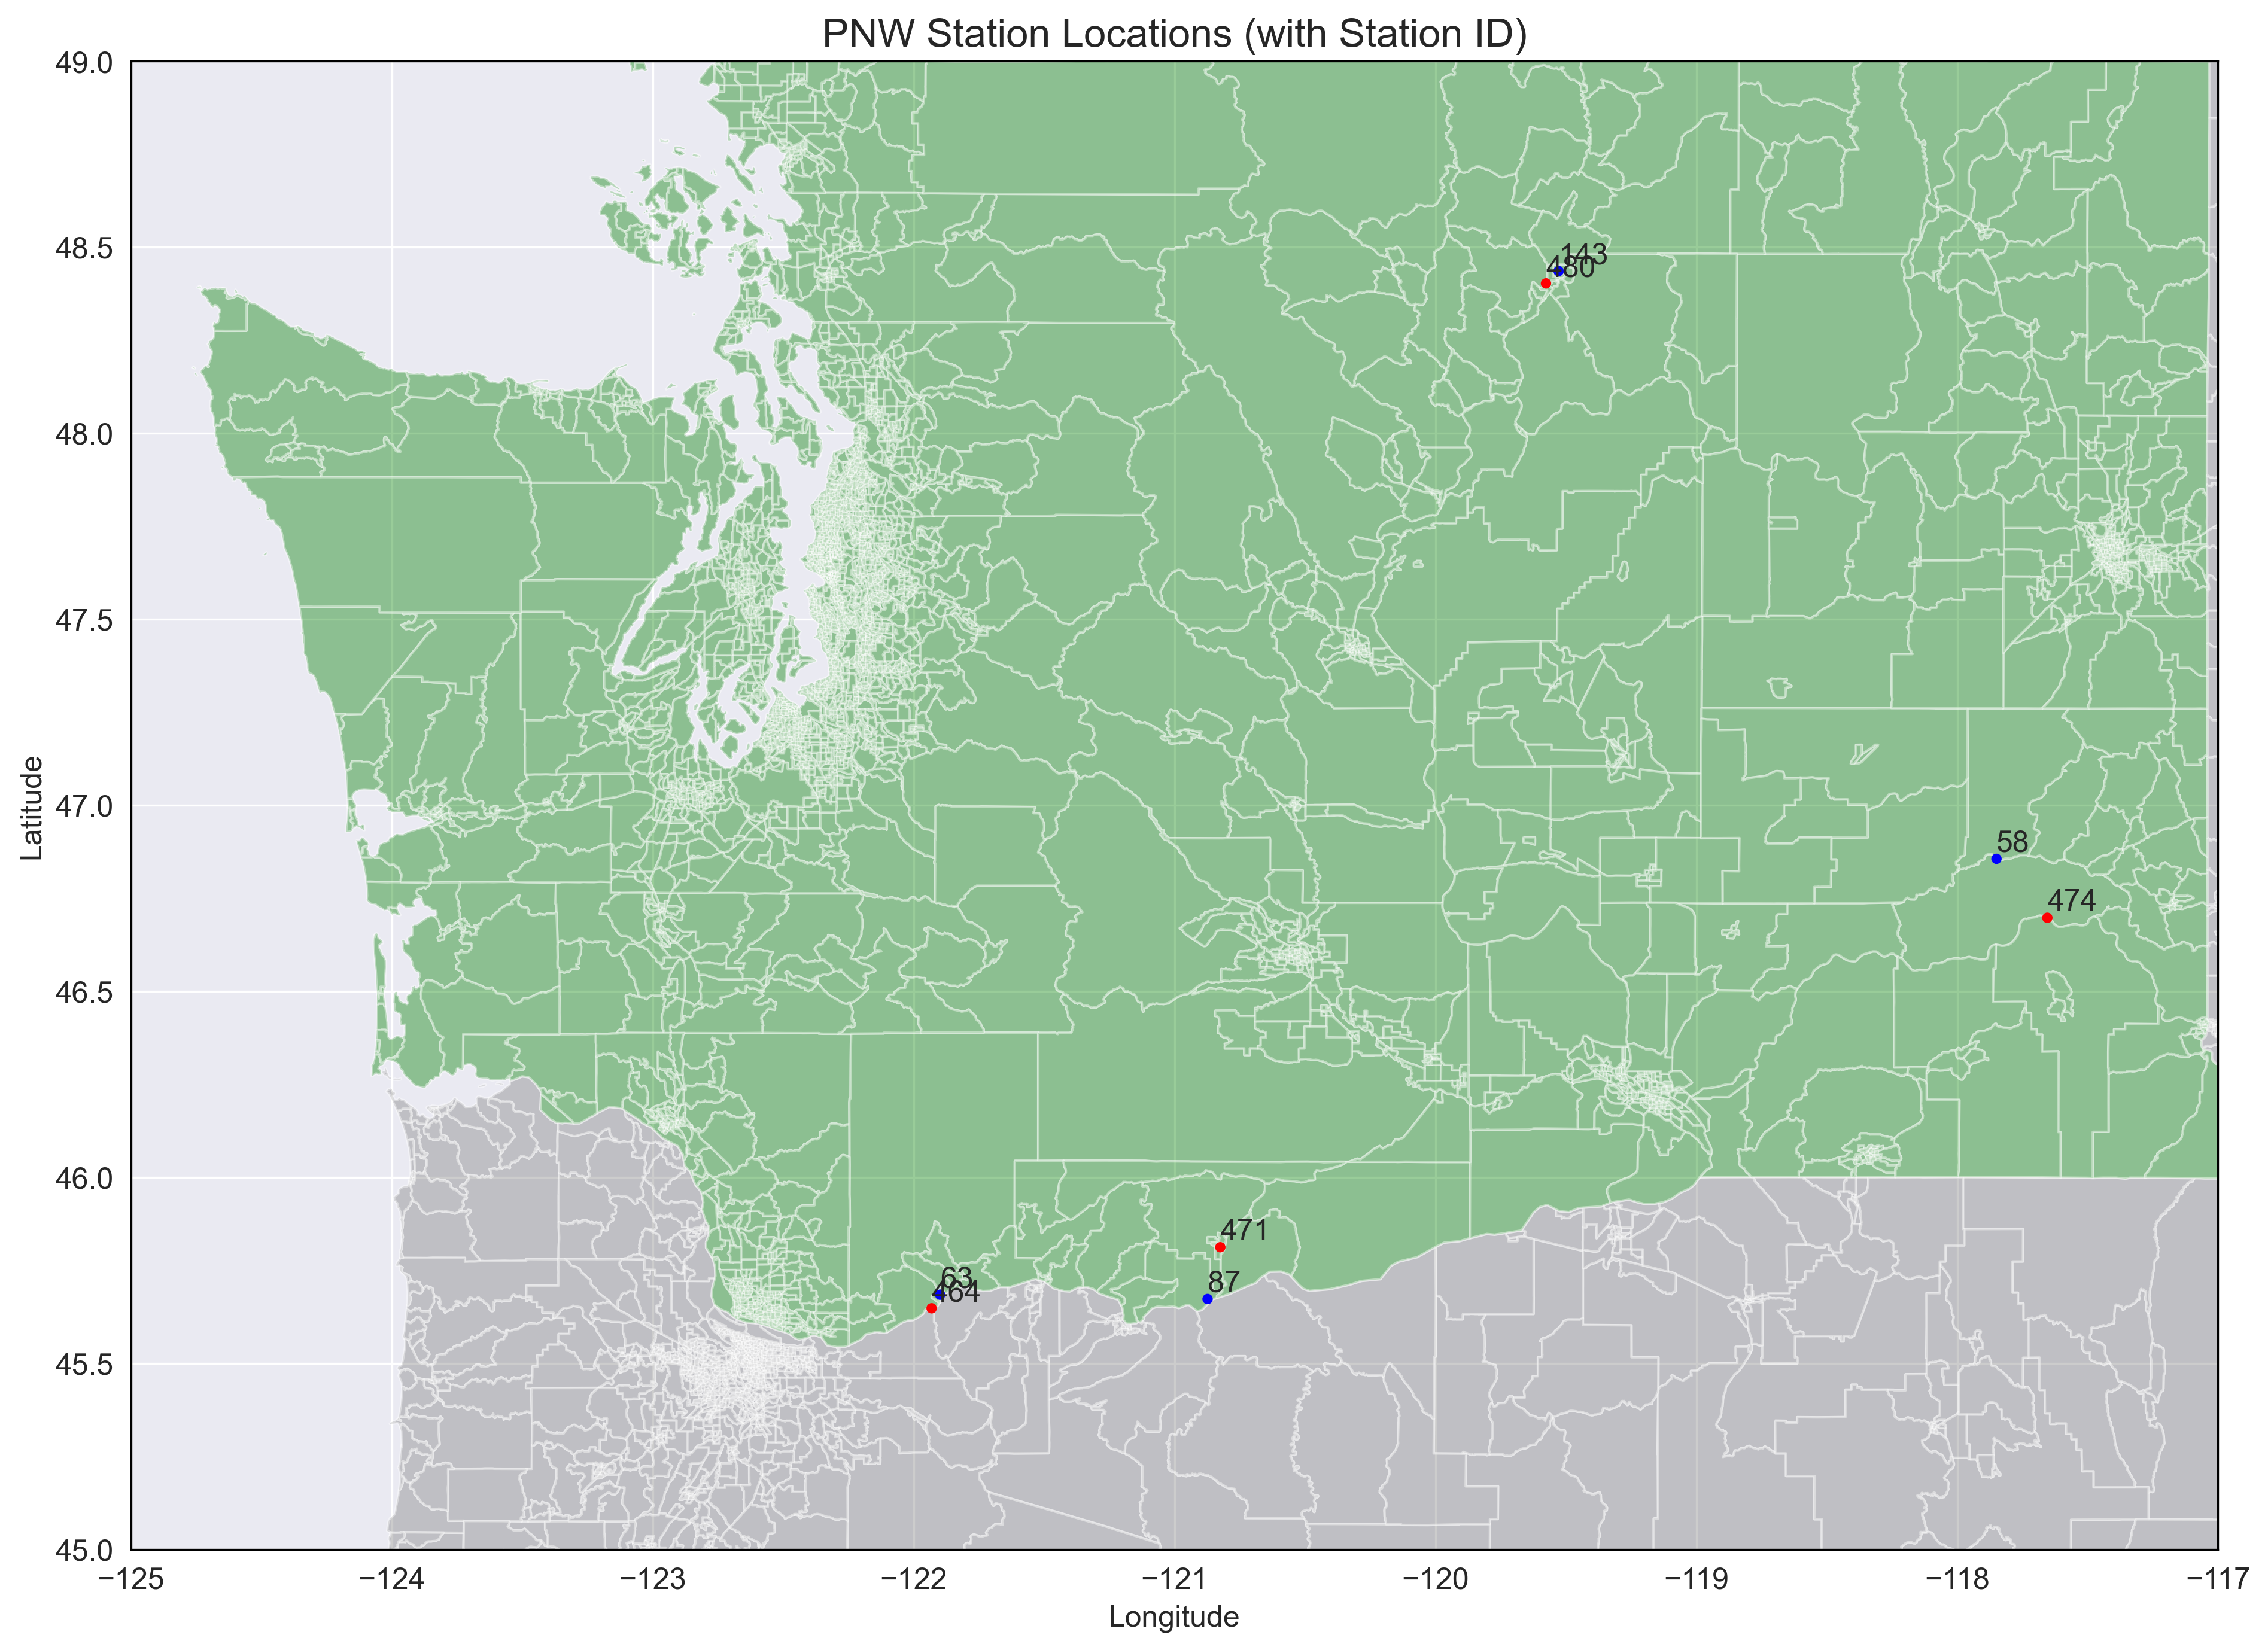

In [4]:
fig, ax = plt.subplots(figsize=(15,15))

map_o.plot(ax=ax, alpha=0.4, color='grey') # oregon (grey)
map_w.plot(ax=ax, alpha=0.4, color='green') # washington (green)
map_i.plot(ax=ax, alpha=0.4, color='grey') # idaho (grey)
plt.scatter(stations.longitude, stations.latitude, c=stations.station_type, s=10)
for i in range(stations.shape[0]):
    plt.text(stations.longitude[i], stations.latitude[i]+0.02, stations.station_id[i])
plt.xlim(-125, -117)
plt.ylim(45, 49)

plt.title('PNW Station Locations (with Station ID)')
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.show();

# below RED is agriment, BLUE is awn

In [7]:
# Need to update pivot function (or just do it manually) to be able to query from awn or agrimet records. 
# Most likely if statement, along with new parameter to function, since queries are different.
def create_agrimet_pivot(s_id):
    '''
    Function takes a station number to load the data from. Query will be ran within the function
    for the given station number.
        
    Returns a tuple of (pivot table, year splits).
    
    Pivot table - each row is a single day, column is tstamp (15 minutes), and values are temperature readings.
    Year splits - index at which each year changes (need for splitting estimation/validation)
    '''
    # Load credentials for login (hidden and not added to repo)
    with open("login_cred.pkl", "rb") as fp:
        config = pickle.load(fp)

    cnx = mysql.connector.connect(**config) # connection point
    
    # Query DB to get timestamp and temp data for specific station data
    s_q = (f"SELECT station_id, tstamp, temp_OBM FROM raw_agrimet_records r WHERE r.station_id = {s_id}")

    data = pd.read_sql(s_q, cnx) # load query into dataframe
    
    data[['date', 'time']] = [str(x).split('T') for x in data.tstamp.values] # Convert tstamp to date and time
    data['time'] = [x.split('.')[:1][0] for x in data.time.values] # Clean up time column
    data = data.drop(['station_id', 'tstamp'], axis=1) # Drop unused columns

    # Pivot with index being date (single day), columns being 24 hour period, values being temp reading
    data_pivot = data.pivot(index='date', columns='time', values='temp_OBM')
    data_pivot.reset_index(inplace=True) # Reset index

    # Set index to be date and remove column name
    data_pivot = data_pivot.set_index('date')
    data_pivot = data_pivot.rename_axis(index=None)
    
    # Find index where year splits
    idx_vals = data_pivot.index.values
    year_splits = [x for x in range (1, len(idx_vals)) if idx_vals[x-1][:4] != idx_vals[x][:4]]
    
    return data_pivot, year_splits

- Side note: looking at these graphs, the original method for getting temperature bounds has similar issues where we are getting valid reading in the lower negative ranges in January. Doing the modified method is keeping them slightly higher (not many more flags are being set either).

Credentials Loaded


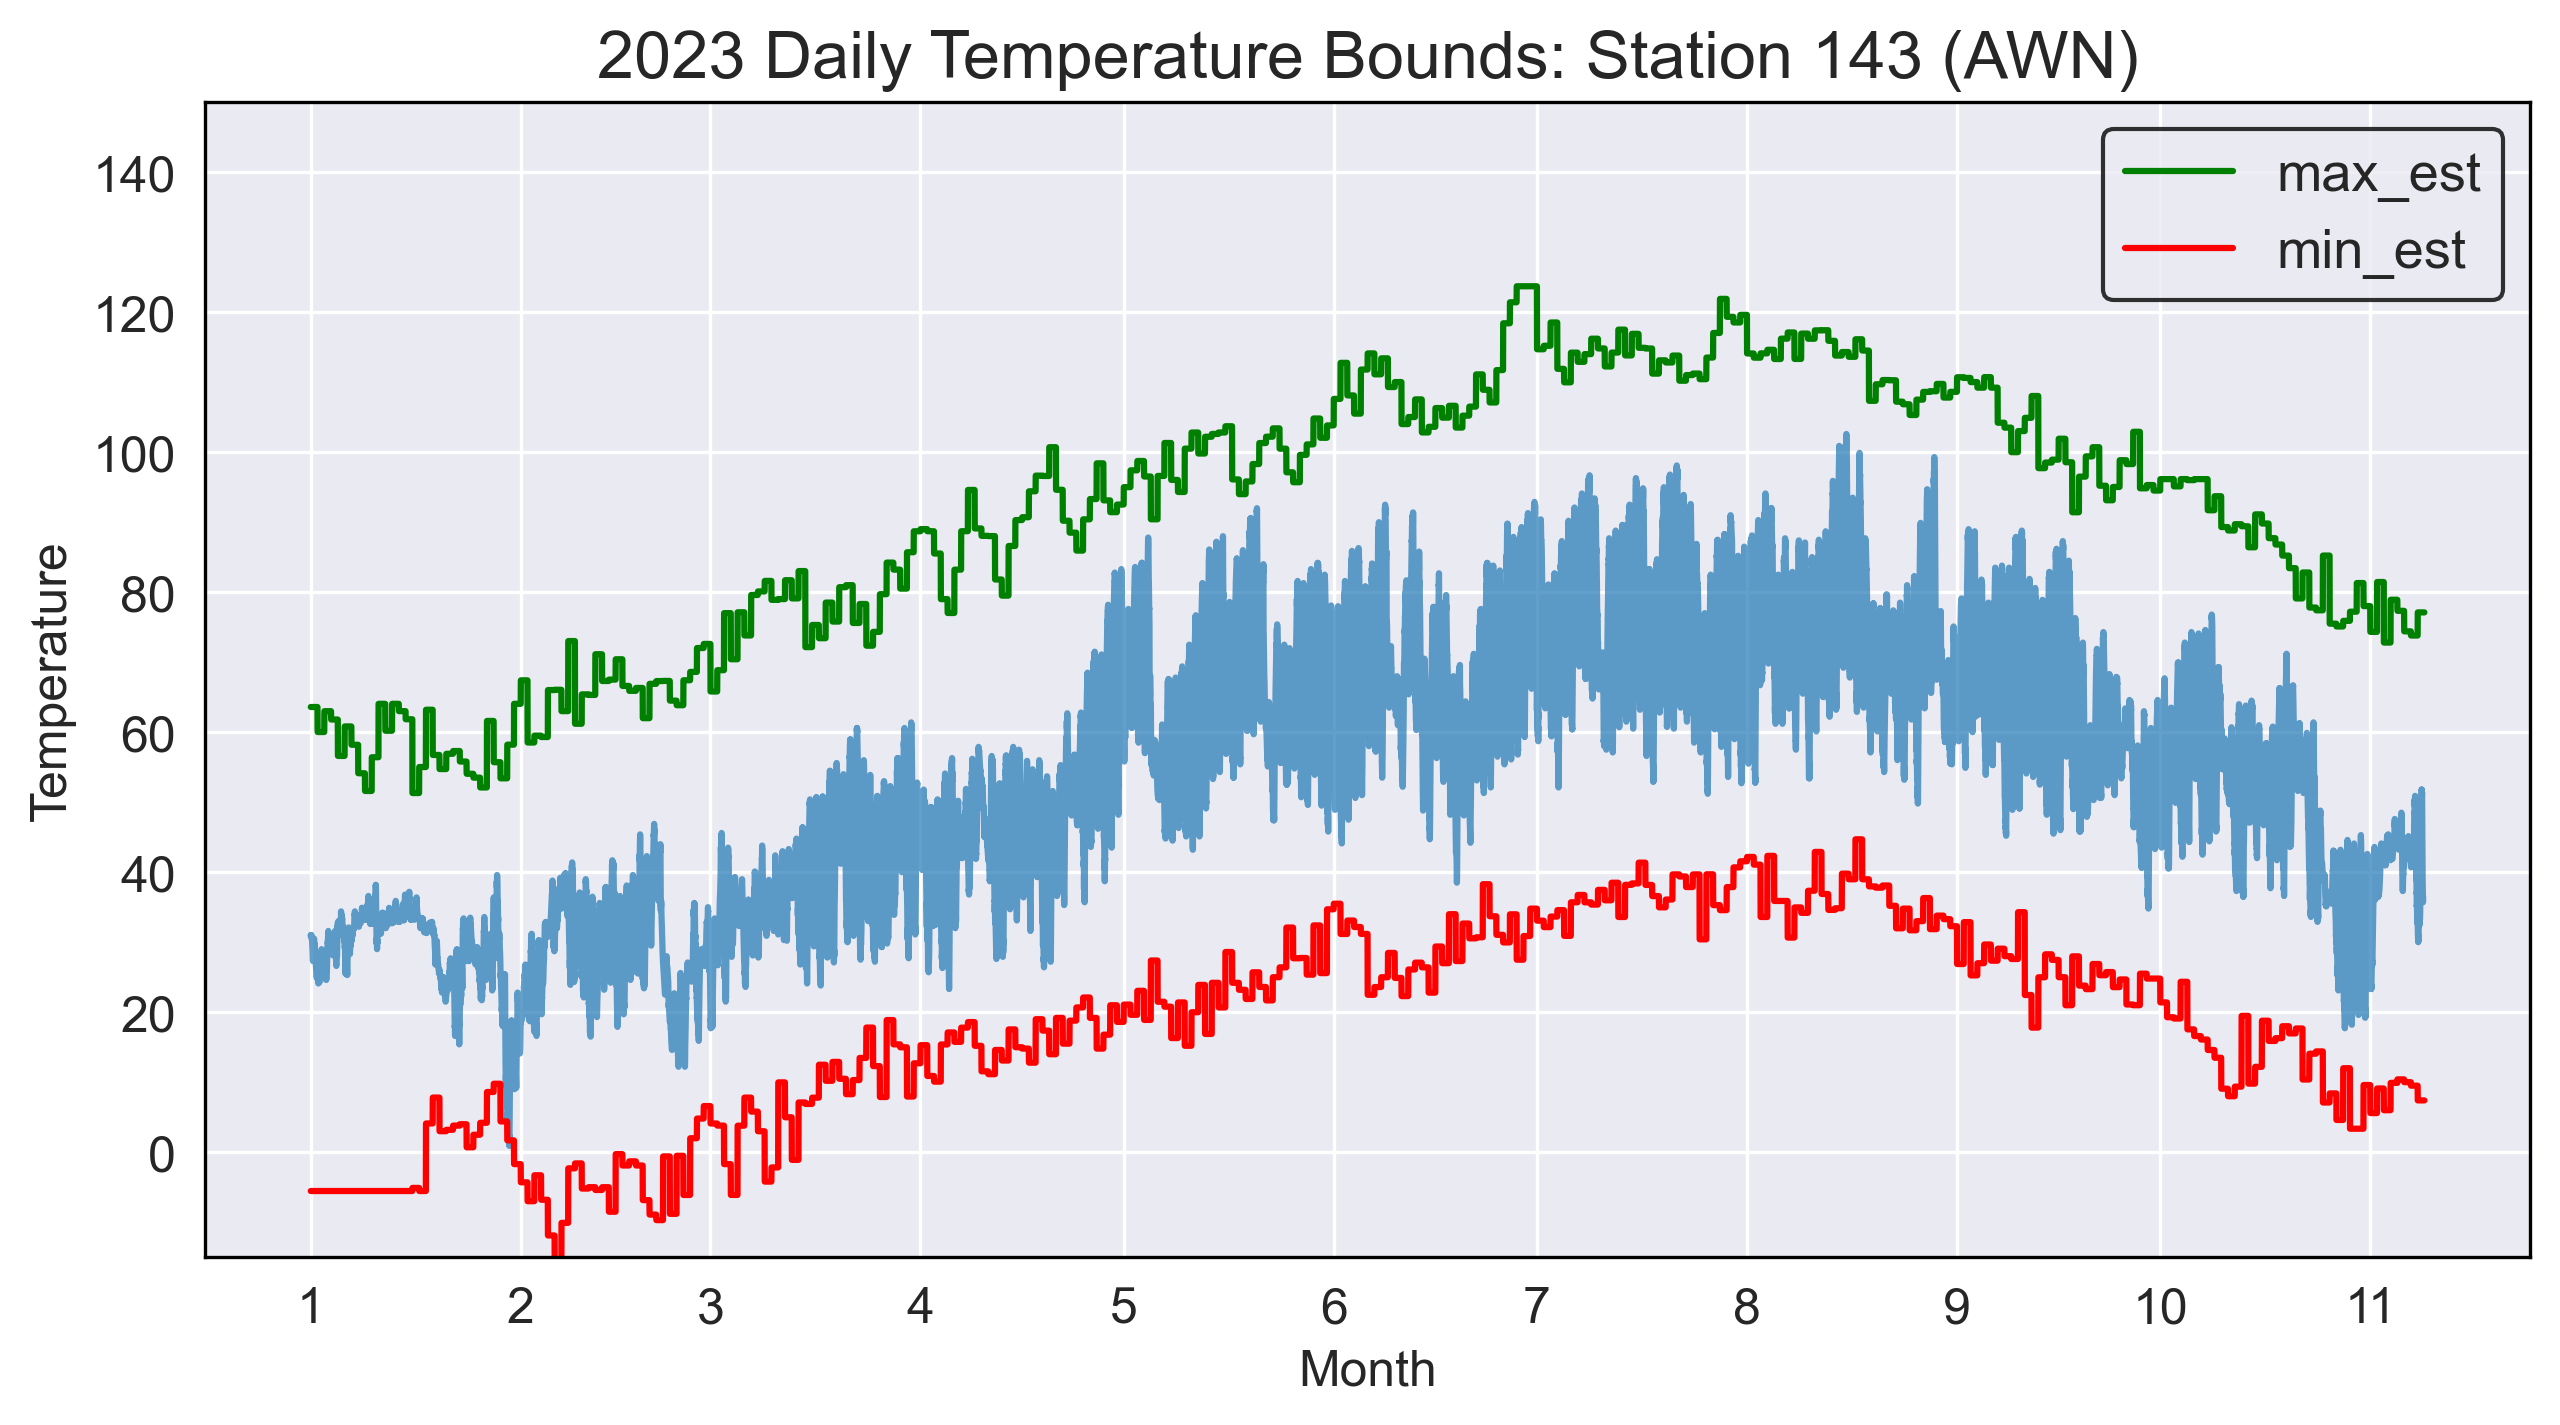

Flags Raised:
Too Hot: 0/29952 ; 0.0%
Too Cold: 4/29952 ; 0.01%
---------------------------------


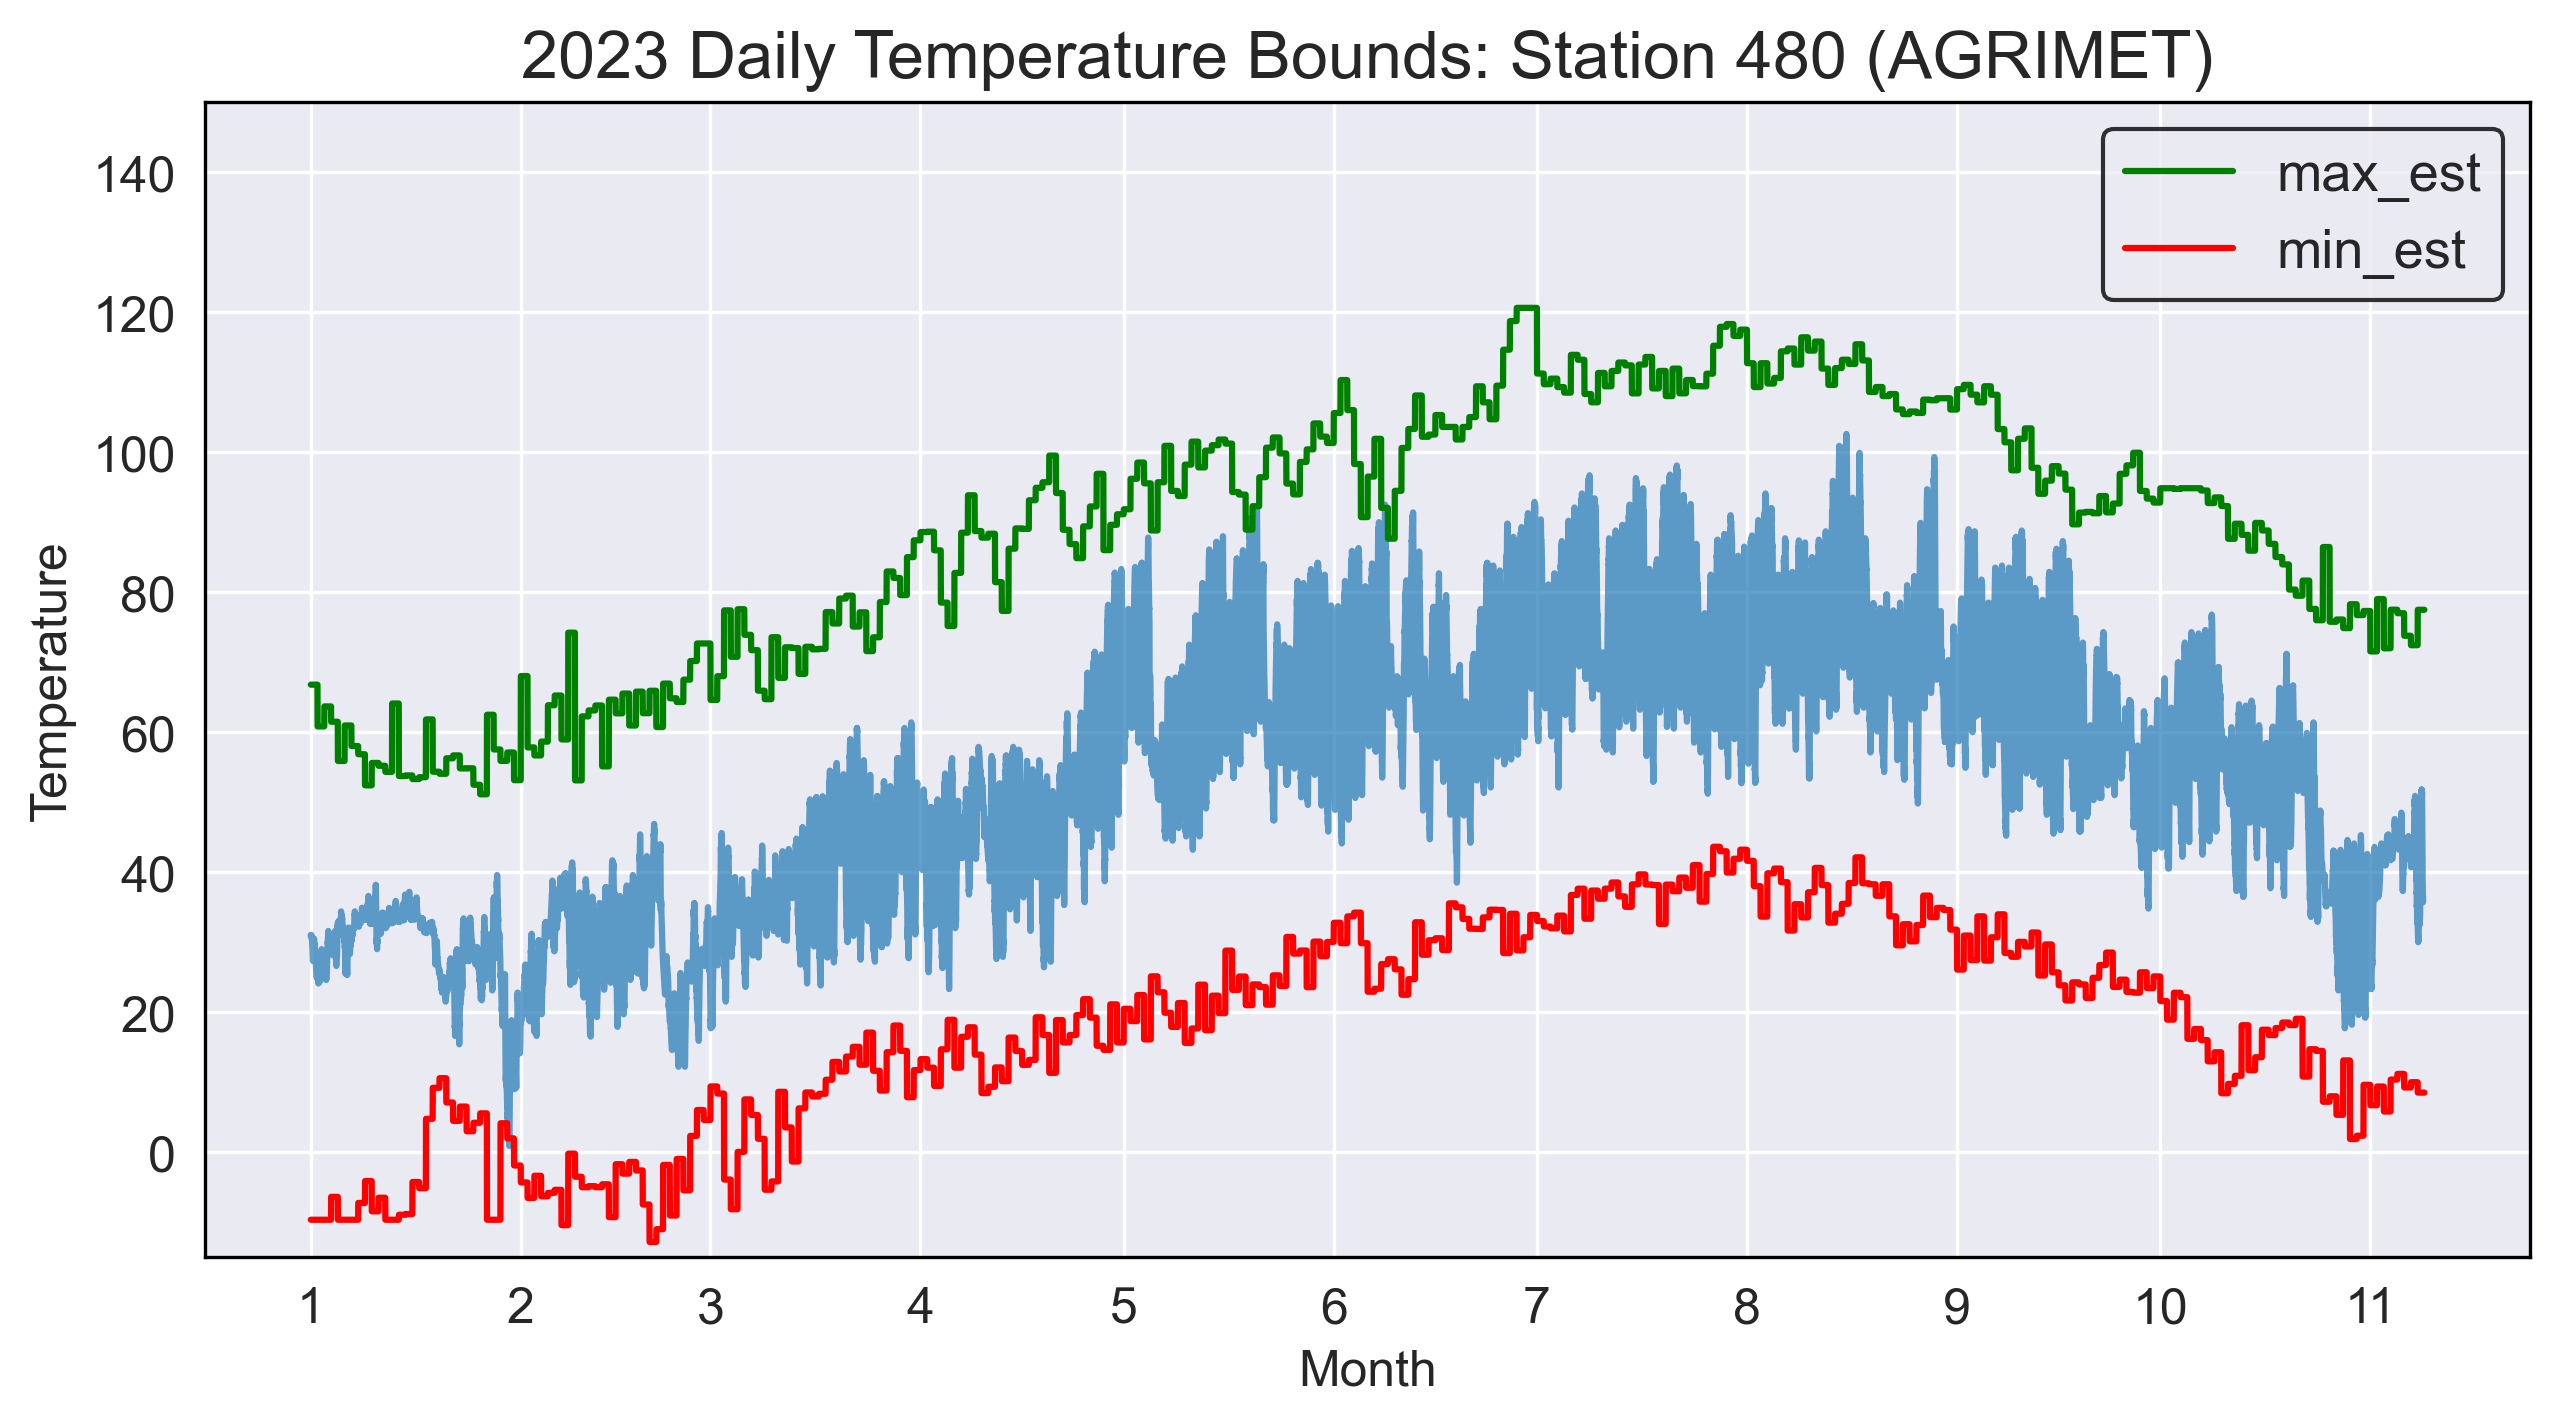

Flags Raised:
Too Hot: 16/29952 ; 0.05%
Too Cold: 6/29952 ; 0.02%
---------------------------------


In [20]:
awn_s = 143
agr_s = 480

# Create pivot table for awn station, split into est/val
awn_pivot, awn_years = create_pivot(awn_s)
awn_pivot_e = awn_pivot.iloc[:awn_years[-1], :] # pull all data from start year - one before latest
awn_pivot_v = awn_pivot.iloc[awn_years[-1]:, :] # pull all data from latest - end

est = temp_bounds_modified(awn_pivot_e, 0.99, 15, 0.8) # Get daily estimates of min/max
temp_val_graph(est, awn_pivot_v, str(awn_s) + ' (AWN)') # Generate graph

# Create pivot table for agrimet station, split into est (no val - use on awn)
agr_pivot, agr_years = create_agrimet_pivot(agr_s)
agr_pivot_e = agr_pivot.iloc[:agr_years[-1], :] # pull all data from start year - one before latest

est_new = temp_bounds_modified(agr_pivot_e, 0.99, 15, 0.8) # Get daily estimates of min/max
temp_val_graph(est_new, awn_pivot_v, str(agr_s) + ' (AGRIMET)') # Generate graph

In [60]:
from scipy.signal import savgol_filter

In [61]:
min_est = est_new.daily_min.values
max_est = est_new.daily_max.values
smoothed_min = savgol_filter(min_est, window_length=15, polyorder=2)
smoothed_max = savgol_filter(max_est, window_length=15, polyorder=2)

In [63]:
est_smoothed = est_new.copy()
est_smoothed['daily_min'] = smoothed_min
est_smoothed['daily_max'] = smoothed_max

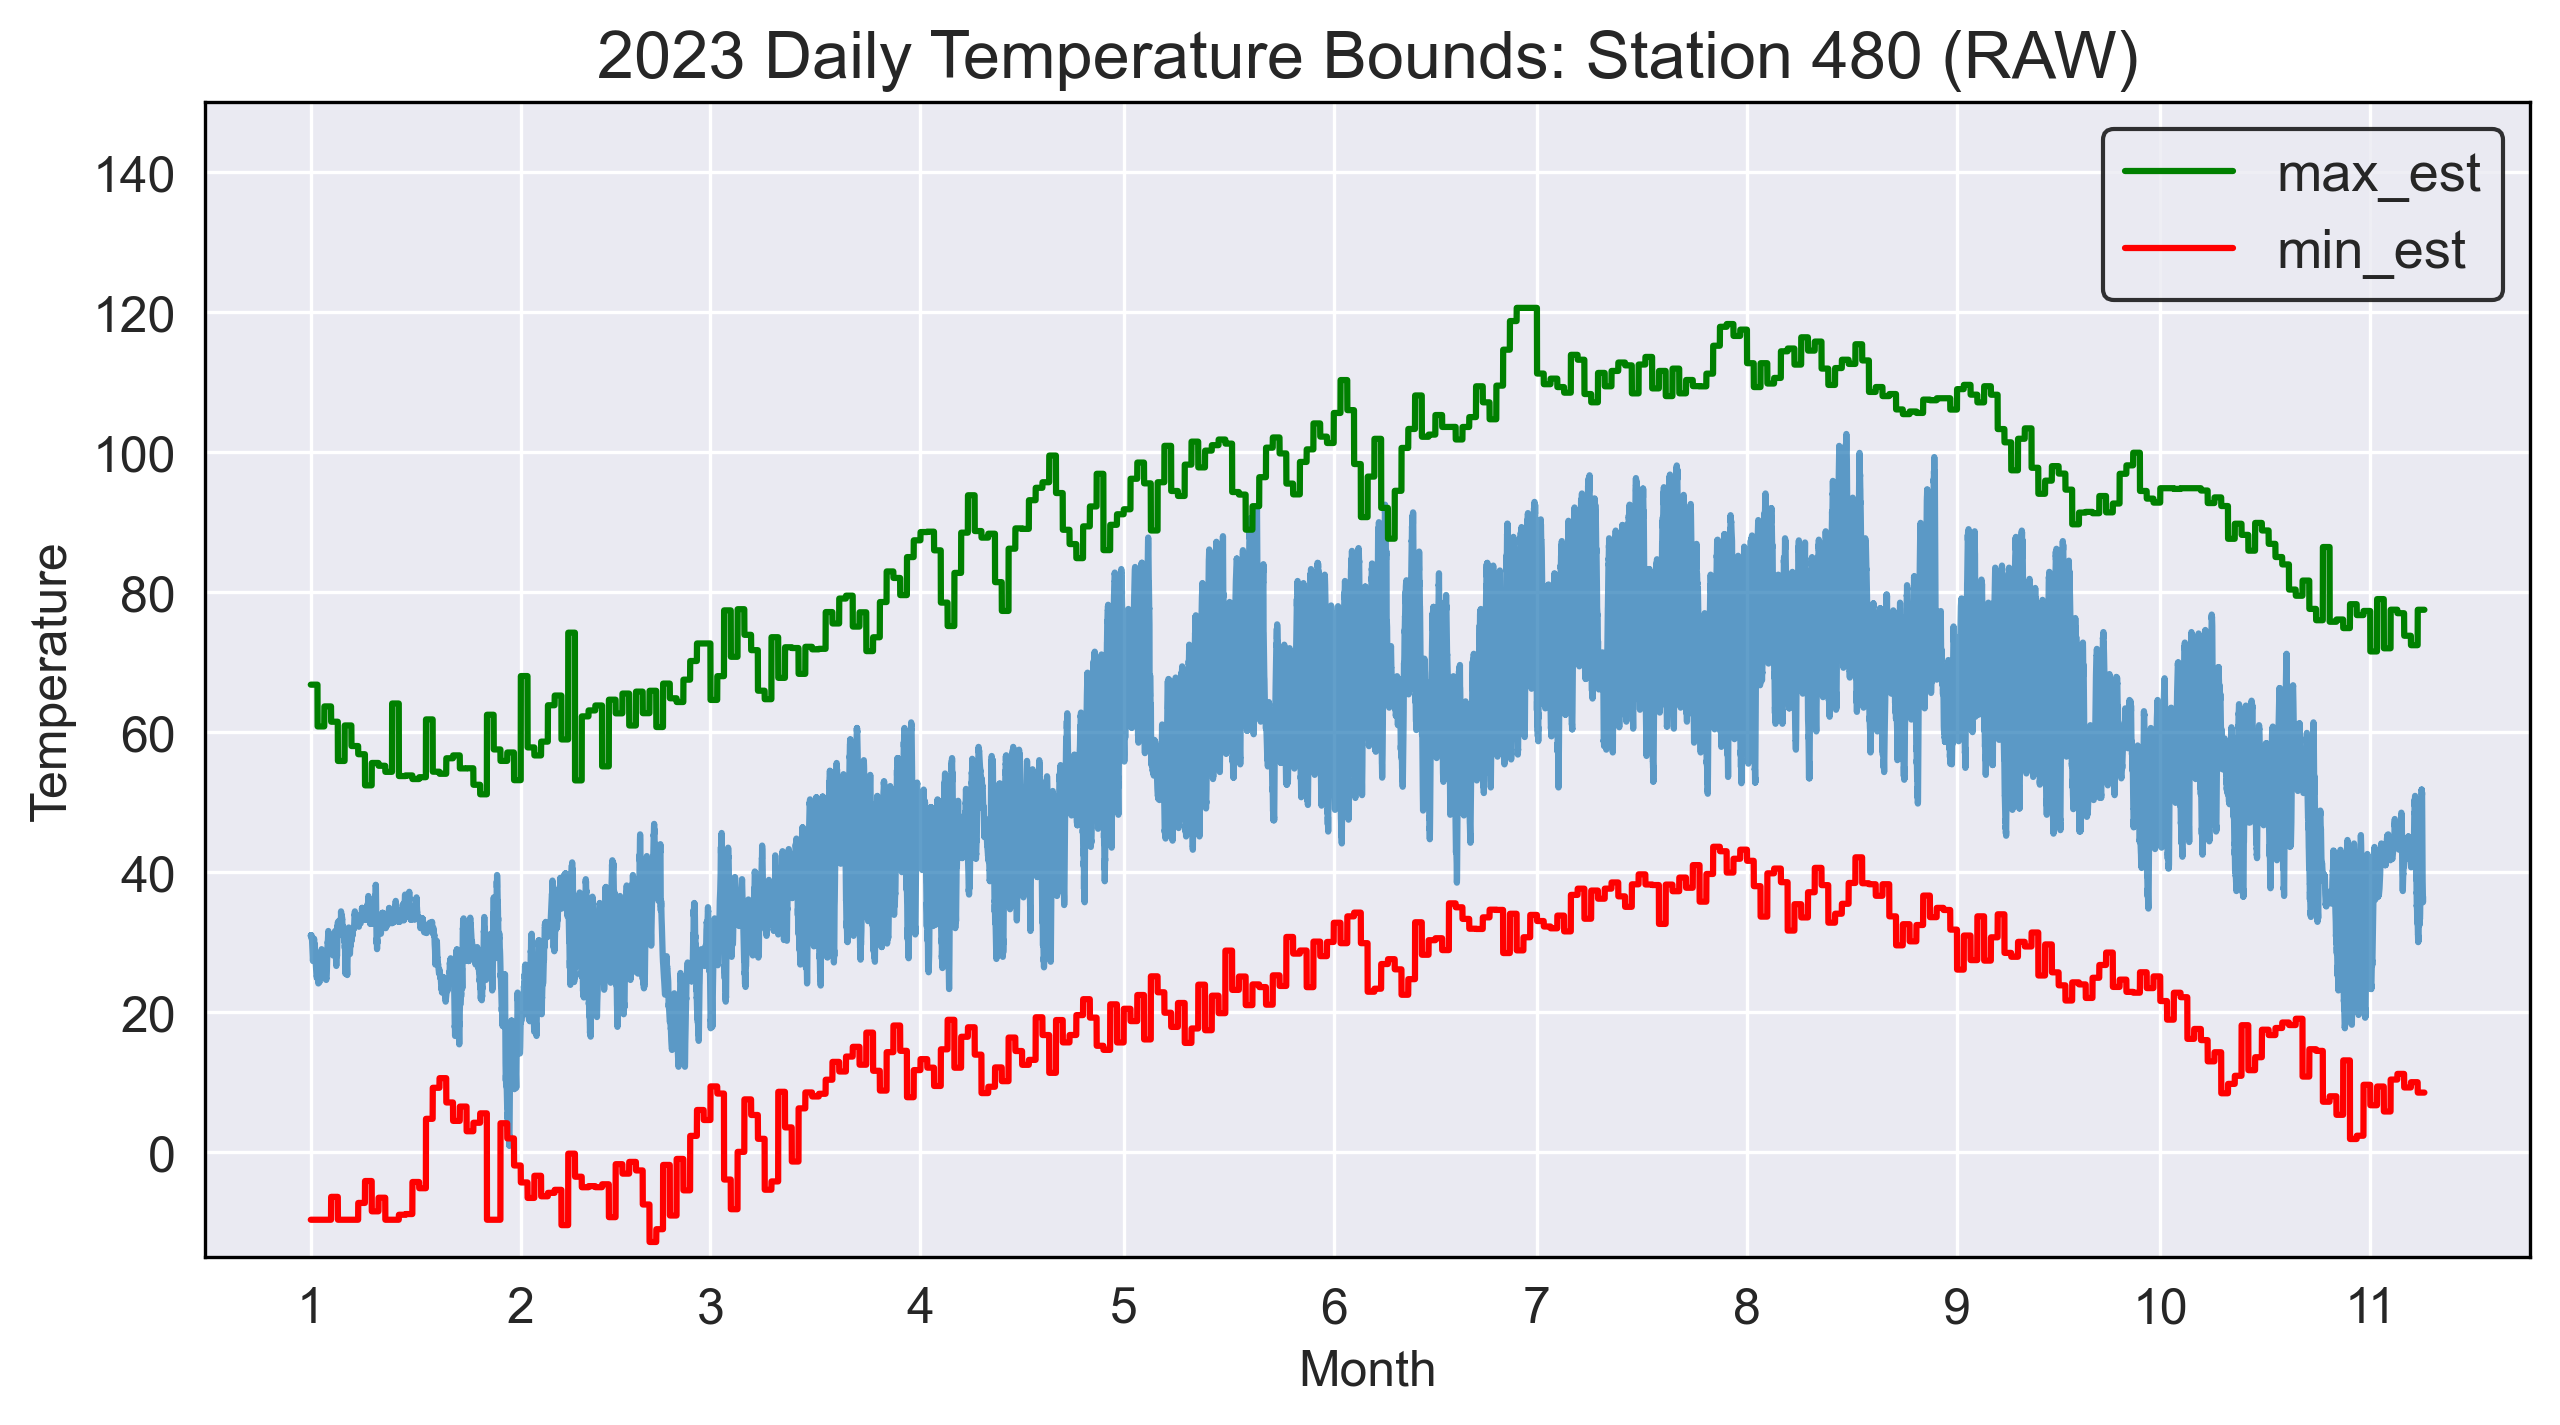

Flags Raised:
Too Hot: 16/29952 ; 0.05%
Too Cold: 6/29952 ; 0.02%
---------------------------------


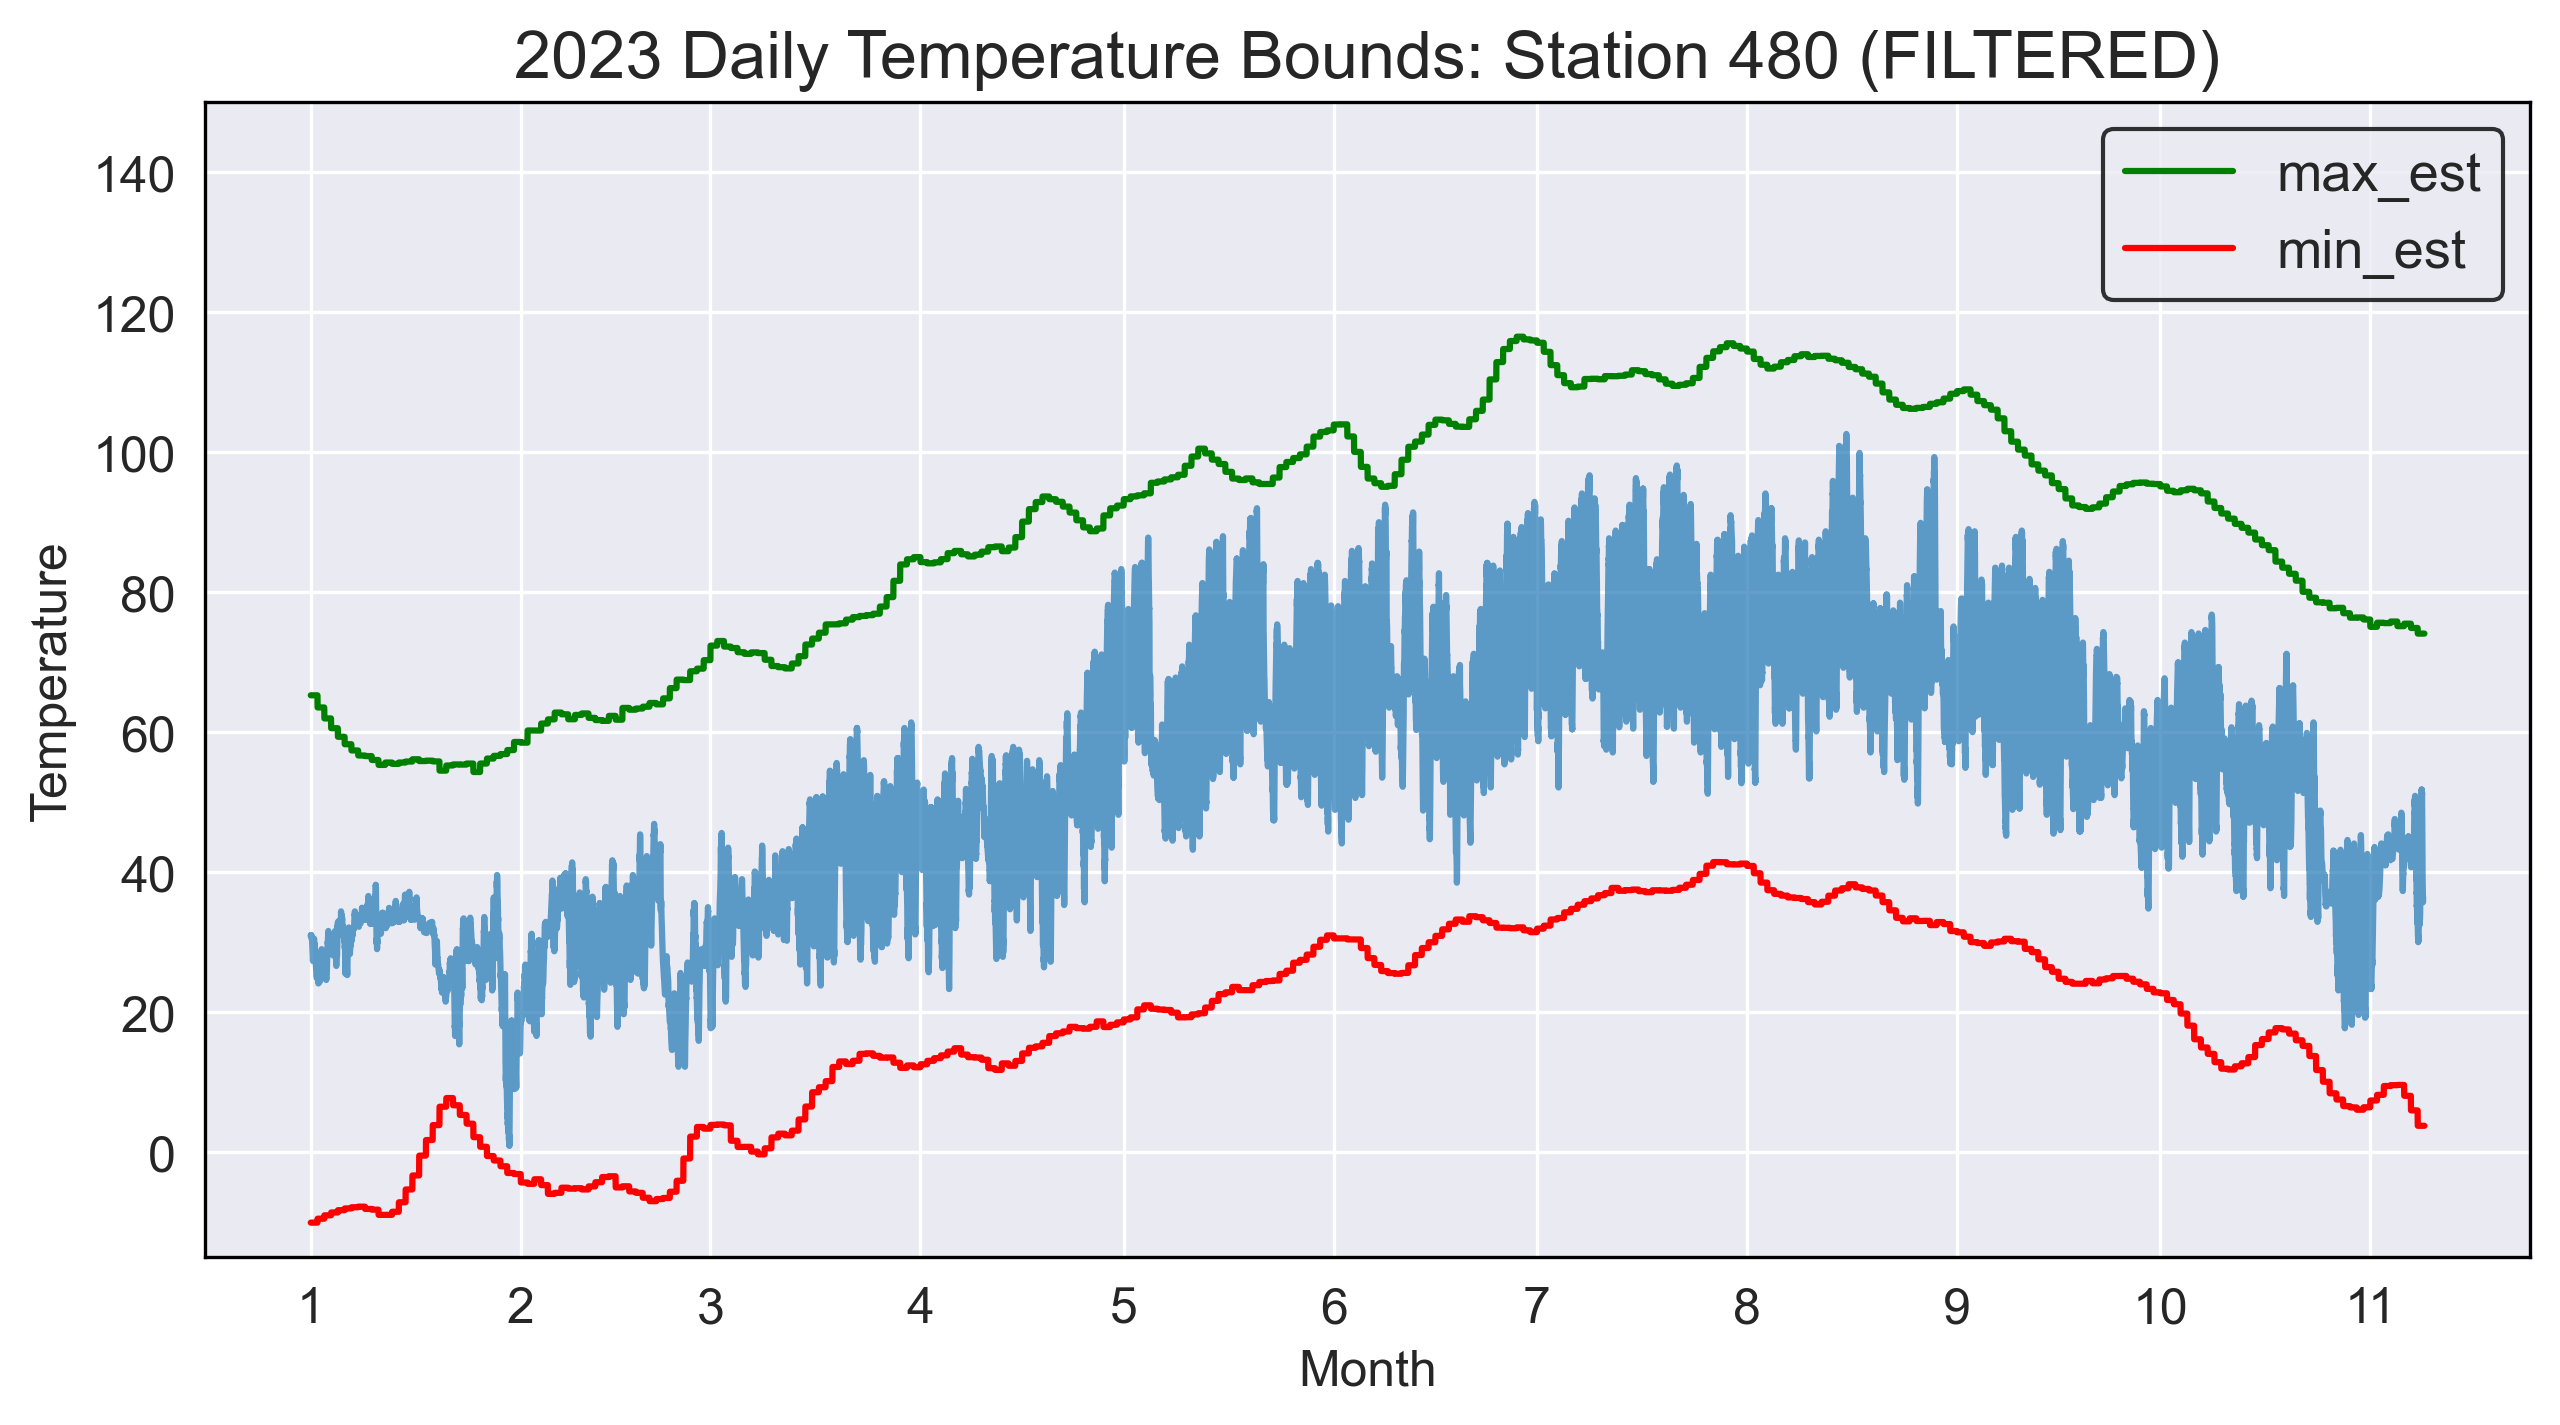

Flags Raised:
Too Hot: 0/29952 ; 0.0%
Too Cold: 0/29952 ; 0.0%
---------------------------------


In [66]:
temp_val_graph(est_new, awn_pivot_v, str(agr_s) + ' (RAW)') # Generate graph
temp_val_graph(est_smoothed, awn_pivot_v, str(agr_s) + ' (FILTERED)') # Generate graph